In [1]:
from google.colab import drive
drive.mount('/content/drive')
# writing a comment

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt

from __future__ import print_function
import sys
from six.moves import cPickle as pickle
import gzip
import seaborn as sns
import string
from time import time
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')
stops = set(stopwords.words("english"))


from IPython.display import display # Allows the use of display() for DataFrames


import warnings
warnings.filterwarnings('ignore')

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

RAN_STATE = 42
FIG_SIZE = (14,8)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
br,lr = pd.read_csv("/content/drive/My Drive/amazon_reviews/beauty_reviews.csv",low_memory=False),\
pd.read_csv("/content/drive/My Drive/amazon_reviews/luxurybeauty_reviews.csv",low_memory=False,thousands=',')
bm,lm = pd.read_csv("/content/drive/My Drive/amazon_reviews/beauty_metadata.csv",low_memory=False),\
pd.read_csv("/content/drive/My Drive/amazon_reviews/luxurybeauty_metadata.csv",low_memory=False)

In [4]:
lr['reviewTime'] = [datetime.strptime(i, '%m %d, %Y').strftime('%Y-%m-%d') for i in lr.reviewTime]
br['reviewTime'] = [datetime.strptime(i, '%Y-%m-%d').strftime('%Y-%m-%d') for i in br.reviewTime]
# lr['vote'] = lr['vote'].replace(",","").astype(float)

In [5]:
display(br.head())
lr = lr[list(br.columns)]
display(lr.head())

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,vote,style
0,1,True,2015-02-19,A1V6B6TNIC10QE,0143026860,great,One Star,NaN,NaN
1,4,True,2014-12-18,A2F5GHSXFQ0W6J,0143026860,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,NaN,NaN
2,4,True,2014-08-10,A1572GUYS7DGSR,0143026860,"This book was very informative, covering all a...",Worth the Read,NaN,NaN
3,5,True,2013-03-11,A1PSGLFK1NSVO,0143026860,I am already a baseball fan and knew a bit abo...,Good Read,NaN,NaN
4,5,True,2011-12-25,A6IKXKZMTKGSC,0143026860,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",5.0,NaN


,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,vote,style
0,2.0,True,2010-06-15,A1Q6MUU0B2ZDQG,B00004U9V2,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,3.0,NaN
1,5.0,True,2010-01-07,A3HO2SQDCZIE9S,B00004U9V2,"Believe me, over the years I have tried many, ...",Best hand cream ever.,14.0,NaN
2,5.0,True,2018-04-18,A2EM03F99X3RJZ,B00004U9V2,Great hand lotion,Five Stars,NaN,{'Size:': ' 3.5 oz.'}
3,5.0,True,2018-04-18,A3Z74TDRGD0HU,B00004U9V2,This is the best for the severely dry skin on ...,Five Stars,NaN,{'Size:': ' 3.5 oz.'}
4,5.0,True,2018-04-17,A2UXFNW9RTL4VM,B00004U9V2,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,NaN,{'Size:': ' 3.5 oz.'}


In [6]:
# br.dtypes

In [7]:
display(bm.head())
lm = lm[list(bm.columns)]
display(lm.head())

,title,brand,rank,asin,description,also_view,also_buy,price,similar_item
0,Workout Headphones by Arena Essentials,HarperCollins,3235148.0,0061073717,NaN,NaN,NaN,NaN,NaN
1,Black Diamond,Swedish Beauty,1462563.0,0143026860,['This is the NEW PURPLE BOTTLE that just came...,['B000LXTNMW'],NaN,NaN,NaN
2,"12 Pc BLUE HEAVEN KAJAL""HERBAL kajal With VITA...",BLUE HEAVE,100425.0,014789302X,"['A brand-new, unused, unopened, undamaged ite...","['B00OWT3W28', 'B0796RMSV8', 'B010E1X15K', 'B0...","['B00OWT3W28', 'B010E1X15K', 'B0796RMSV8', 'B0...",6.45,NaN
3,The Inheritance,Sunatoria,476831.0,0571348351,"[""You have to wonder why there isn't a word in...","['0571352367', '0573697094', '1635571766', '15...","['1848426380', 'B07JVF7M3C', '1644450003', '16...",NaN,NaN
4,The Listening Cards,Listening Planet,2967592.0,0692508988,['The Listening Cards are an eloquent primer i...,NaN,NaN,NaN,NaN


,title,brand,rank,asin,description,also_view,also_buy,price,similar_item
0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,NaN,"4,324 in Beauty & Personal Care (",B00004U9V2,['After a long day of handling thorny situatio...,"['B00FRERO7G', 'B00GHX7H0A', 'B07GFHJRMX', 'B0...","['B00GHX7H0A', 'B00FRERO7G', 'B00R68QXCS', 'B0...",$30.00,NaN
1,AHAVA Bath Salts,NaN,"1,633,549 in Beauty & Personal Care (",B0000531EN,"[""If you haven't experienced the pleasures of ...",[],[],NaN,NaN
2,"AHAVA Dead Sea Mineral Mud, 8.5 oz, Pack of 4",NaN,"1,806,710 in Beauty &amp; Personal Care (",B0000532JH,"[""Rich, black mineral mud, harvested from the ...",[],[],NaN,NaN
3,"Crabtree &amp; Evelyn Hand Soap, Gardeners, 10...",NaN,[],B00005A77F,['This liquid soap with convenient pump dispen...,"['B00004U9V2', 'B00GHX7H0A', 'B00FRERO7G', 'B0...",[],$15.99,NaN
4,Soy Milk Hand Crme,NaN,"42,464 in Beauty &amp; Personal Care (",B00005NDTD,"[""Remember why you love your favorite blanket?...",[],"['B000NZT6KM', 'B001BY229Q', 'B008J724QY', 'B0...",$18.00,NaN


In [8]:
# pd.options.display.max_rows
# pd.set_option('display.max_colwidth', None)
# lr[lr["vote"].isna()][["reviewText"]].head(30)

In [9]:
# display(beauty[beauty["vote"]==0]) 
# display(luxury[luxury["vote"]==0]) 
# beauty['vote'] = beauty['vote'].fillna(0)
# luxury['vote'] = luxury['vote'].fillna(0)

#What proportion of the dataset does it represent?
print('We have', len(br), 'reviews in the dataset and', 
      str(round((1 - len(br.dropna(subset=['vote']))/len(br))*100, 2)) + '%', 
      'are missing the vote value.')
print('It means that we will be working on', str(round(len(br.dropna(subset=['vote']))/len(br)*100, 2)) 
      + '%', 'of the dataset, that is', int(len(br.dropna(subset=['vote']))/len(br)*len(br)),
      'reviews.')

print('We have', len(lr), 'reviews in the dataset and', 
      str(round((1 - len(lr.dropna(subset=['vote']))/len(lr))*100, 2)) + '%', 
      'are missing the vote value.')
print('It means that we will be working on', str(round(len(lr.dropna(subset=['vote']))/len(lr)*100, 2)) 
      + '%', 'of the dataset, that is', int(len(lr.dropna(subset=['vote']))/len(lr)*len(lr)),
      'reviews.')

We have 371345 reviews in the dataset and 86.02% are missing the vote value.
It means that we will be working on 13.98% of the dataset, that is 51899 reviews.
We have 574628 reviews in the dataset and 81.96% are missing the vote value.
It means that we will be working on 18.04% of the dataset, that is 103689 reviews.


In [10]:
display(br.groupby("verified").count())
display(lr.groupby("verified").count())

br = br.dropna(subset=['vote'])
lr = lr.dropna(subset=['vote'])

br = br.loc[br.verified, :]
lr = lr.loc[lr.verified, :]

,overall,reviewTime,reviewerID,asin,reviewText,summary,vote,style
verified,,,,,,,,
False,48872,48872,48872,48872,48848,48858,11375,15842
True,322473,322473,322473,322473,322098,322276,40524,110116


,overall,reviewTime,reviewerID,asin,reviewText,summary,vote,style
verified,,,,,,,,
False,70086,70086,70086,70086,70064,70070,16373,30626
True,504542,504542,504542,504542,504164,504370,87316,220387


In [11]:
#We want to keep only the reviews that were written maximum 7 days before the max date of the dataset
#We define a date threshold and keep only the reviews written before that threshold
datelim_b = (datetime.strptime(max(br.reviewTime), '%Y-%m-%d') - timedelta(days = 7)).strftime('%Y-%m-%d')

# print('The current max date is', max(combo.reviewTime))
# print('The amount of reviews that were written at least 7 days before that date represents',
#       str(round(len(combo[combo['reviewTime'] < datelim])/len(combo),6)*100) + '% of the dataset, that is',
#       len(combo[combo['reviewTime'] < datelim]), 'reviews.')

datelim_l = (datetime.strptime(max(lr.reviewTime), '%Y-%m-%d') - timedelta(days = 7)).strftime('%Y-%m-%d')

# print('The current max date is', max(combo.reviewTime))
# print('The amount of reviews that were written at least 7 days before that date represents',
#       str(round(len(combo[combo['reviewTime'] < datelim])/len(combo),6)*100) + '% of the dataset, that is',
#       len(combo[combo['reviewTime'] < datelim]), 'reviews.')

print("Beauty " + datelim_b) 
print("Luxury " + datelim_l)

Beauty 2018-09-18
Luxury 2018-08-22


In [12]:
br = br[br['reviewTime'] < datelim_b]
lr = lr[lr['reviewTime'] < datelim_b]

In [13]:
br[['vote_stan']] = StandardScaler().fit_transform(br[['vote']])
lr[['vote_stan']] = StandardScaler().fit_transform(lr[['vote']])

br[['vote_norm']] = MinMaxScaler().fit_transform(br[['vote']])
lr[['vote_norm']] = MinMaxScaler().fit_transform(lr[['vote']])

In [14]:
reviews = pd.concat([br, lr], axis = 0)

In [15]:
print('We have', str(round((1 - len(reviews.drop_duplicates(subset=['reviewerID', 'asin', 'reviewText']))\
                            /len(reviews))*100,2))
      + '%', 'duplicate reviews in the dataset.')
print('We will remove them, meaning that our dataset contains now', 
      len(reviews.drop_duplicates(subset=['reviewerID', 'asin', 'reviewText'])), 'reviews.')

We have 5.18% duplicate reviews in the dataset.
We will remove them, meaning that our dataset contains now 121212 reviews.


In [16]:
reviews = reviews.sort_values(by="vote",ascending=False).drop_duplicates(subset=['reviewerID', 'asin', 'reviewText'])

In [17]:
# reviews[["vote_stan"]].nlargest(20, ['vote_stan'])

121212
120879


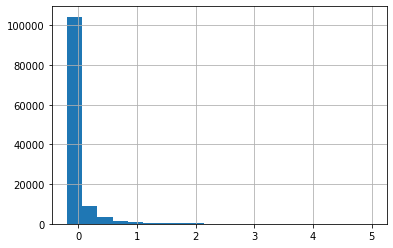

In [18]:
# hist_df = combo.loc[~(combo["vote"]==0)]
hist_df = reviews.loc[~(reviews["vote_stan"]>5)]
print(len(reviews))
print(len(hist_df))
hist_df.vote_stan.hist(bins=20)
# combo.vote.hist(bins=3)

121212
121185


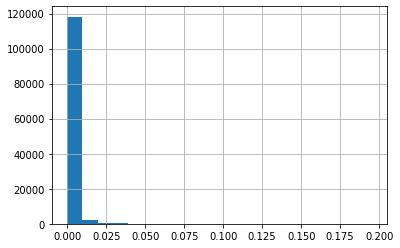

In [19]:
# hist_df = combo.loc[~(combo["vote"]==0)]
hist_df = reviews.loc[~(reviews["vote_norm"]>.2)]
print(len(reviews))
print(len(hist_df))
hist_df.vote_norm.hist(bins=20)
# combo.vote.hist(bins=3)

In [20]:
reviews.sort_values(by="vote_norm", ascending=False).head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,vote,style,vote_stan,vote_norm
22623,4.0,True,2015-11-14,A2J0S1IC4PU9G8,B0002ZW5UQ,"So, if you're bothering to read reviews about ...","Not bad, Toppik, but let's be clear about a fe...",2995.0,"{'Size:': ' 0.42 oz.', 'Color:': ' Dark Brown'}",120.077389,1.000000
134223,5.0,True,2011-10-24,A2LXX47A0KMJVX,B000FOI48G,"<div id=""video-block-R2HEG12C48KXPW"" class=""a-...","Very happy with this. Quiet operation, large w...",2721.0,NaN,100.249017,1.000000
39144,5.0,True,2011-10-24,A2LXX47A0KMJVX,B000GLRREU,"<div id=""video-block-R2HEG12C48KXPW"" class=""a-...","Very happy with this. Quiet operation, large w...",2713.0,{'Size:': ' Ultra'},99.953594,0.997058


In [21]:
reviews = pd.read_csv("/content/drive/My Drive/amazon_reviews/model_data.csv",low_memory=False)
dashboard = pd.read_csv("/content/drive/My Drive/amazon_reviews/dashboard_data.csv",low_memory=False)


In [22]:
reviews.loc[reviews.vote_norm >= .07, 'helpful'] = 1
reviews.loc[reviews.vote_norm < .07, 'helpful'] = 0

In [23]:
reviews.groupby("helpful").count()

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,vote,style,vote_stan,vote_norm,sentiment
helpful,,,,,,,,,,,,
0.0,60231,60231,60231,60231,60231,60185,60212,60231,22901,60231,60231,51546
1.0,105,105,105,105,105,105,105,105,49,105,105,92


In [24]:
reviews.loc[:, 'reviewText'] = reviews['reviewText'].str.lower()

In [25]:
reviews = reviews.astype({"reviewText": str})
reviews.reviewText.dtypes

dtype('O')

In [26]:
def remove_punctuation(text):
    # return text.translate(None, string.punctuation.translate(None, '"'))
    return text.translate(str.maketrans('','',string.punctuation))
def remove_nums(text):
    return text.translate(str.maketrans('','','1234567890'))

reviews['reviewText']=reviews['reviewText'].apply( lambda x: remove_punctuation(x))
reviews['reviewText']=reviews['reviewText'].apply( lambda x: remove_nums(x))

# text = text.translate(str.maketrans('','',string.punctuation))
# reviews['reviewText'] = reviews['reviewText'].apply( lambda x: x.translate(str.maketrans('','',string.punctuation)))
reviews['reviewText'].head(10)

0    div idvideoblockrhegckxpw classasection aspaci...
1    everyone has different experiences but the fla...
2    i got one area of my body that i want to get r...
3    this is long but important i have very thick a...
4    im not sure why they dont refer to this waterp...
5    im not sure why they dont refer to this waterp...
6    ive been reading great reviews but users compl...
7    a datahookproductlinklinked classalinknormal h...
8    this is the best deodorant ive used since swit...
9    i purchased this unit after seeing the infomer...
Name: reviewText, dtype: object

In [27]:
#tokenize text with Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

#create a stemmer
stemmer = SnowballStemmer("english")


#define our own tokenizing function that we will pass into the TFIDFVectorizer. We will also stem the words here.
def tokens(x):
    x = x.split()
    stems = []
    [stems.append(stemmer.stem(word)) for word in x]
    return stems

#loads pickle if exists, extracts and pickles if it doesn't
if os.path.exists('features.pickle'):
    print ('Pickled file already present, loading...')
    features = pickle.load( open( "features.pickle", "rb" ) )
    print ('Pickle file loaded.')
else:
    #define the vectorizer
    vectorizer = TfidfVectorizer(tokenizer = tokens, stop_words = 'english', ngram_range=(1, 1), min_df = 0.01, max_features=478)
    #fit the vectorizers to the data.
    features = vectorizer.fit_transform(reviews['reviewText'])
features

<60336x478 sparse matrix of type '<class 'numpy.float64'>'
	with 1053215 stored elements in Compressed Sparse Row format>

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,reviews['helpful'], test_size=0.2, random_state=42)

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on roc_auc score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    probas = clf.predict_proba(features)
    end = time()
    
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    return roc_auc_score(target.values, probas[:,1].T)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on roc_auc score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, X_train.shape[0]))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print ("ROC_AUC score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print ("ROC_AUC score for test set: {:.4f}.\n".format(predict_labels(clf, X_test, y_test)))
    
def clf_test_roc_score(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    probas = probas =clf.predict_proba(X_test)
    return roc_auc_score(y_test, probas[:,1].T)

In [30]:
# Import the supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


# Initialize the models using a random state were applicable.
clf_list = [GaussianNB(), 
            AdaBoostClassifier(random_state = RAN_STATE), 
            RandomForestClassifier(random_state = RAN_STATE), 
            LogisticRegression(random_state = RAN_STATE),
            DecisionTreeClassifier(random_state = RAN_STATE)]
x_tr = X_train.toarray()
x_te = X_test.toarray()


# Set up the training set sizes for 100, 200 and 300 respectively.
train_feature_list = [x_tr[0:10000],x_tr[0:20000],x_tr]
train_target_list = [y_train[0:10000], y_train[0:20000], y_train]


# Execute the 'train_predict' function for each of the classifiers and each training set size
for clf in clf_list:
    for a, b in zip(train_feature_list, train_target_list):
        train_predict(clf, a, b, x_te, y_test)

Training a GaussianNB using a training set size of 10000. . .
Trained model in 0.0778 seconds
Made predictions in 0.0663 seconds.
ROC_AUC score for training set: 0.8887.
Made predictions in 0.0933 seconds.
ROC_AUC score for test set: 0.3840.

Training a GaussianNB using a training set size of 20000. . .
Trained model in 0.2827 seconds
Made predictions in 0.1188 seconds.
ROC_AUC score for training set: 0.8188.
Made predictions in 0.0796 seconds.
ROC_AUC score for test set: 0.3329.

Training a GaussianNB using a training set size of 48268. . .
Trained model in 0.4447 seconds
Made predictions in 0.2660 seconds.
ROC_AUC score for training set: 0.8547.
Made predictions in 0.0763 seconds.
ROC_AUC score for test set: 0.5844.

Training a AdaBoostClassifier using a training set size of 10000. . .
Trained model in 5.1952 seconds
Made predictions in 0.6436 seconds.
ROC_AUC score for training set: 1.0000.
Made predictions in 0.7780 seconds.
ROC_AUC score for test set: 0.3695.

Training a AdaBoostC

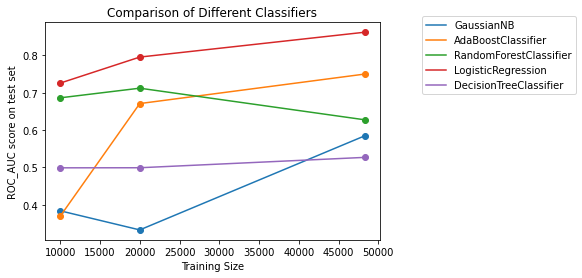

<Figure size 1008x576 with 0 Axes>

In [31]:
### Visualize all of the classifiers                                                               
for clf in clf_list:
    x_graph = []
    y_graph = []
    for a, b in zip(train_feature_list, train_target_list):
        y_graph.append(clf_test_roc_score(clf, a, b, x_te, y_test))
        x_graph.append(len(a))
    plt.scatter(x_graph,y_graph)
    plt.plot(x_graph,y_graph, label = clf.__class__.__name__)

plt.title('Comparison of Different Classifiers')
plt.xlabel('Training Size')
plt.ylabel('ROC_AUC score on test set')
plt.legend(bbox_to_anchor=(1.6, 1.05))
plt.figure(figsize=FIG_SIZE)             
plt.show()

In [32]:
random_numbers = range(1,101)
tot = 0.0
for seed in random_numbers:
    clf3 = LogisticRegression(random_state=seed)
    clf3.fit(X_train, y_train)
    probas =clf3.predict_proba(X_test)
    tot += roc_auc_score(y_test, probas[:,1].T)
    
print ('Average ROC_AUC Score for 1-100 random_state: {:.4f}'.format(tot/100))

Average ROC_AUC Score for 1-100 random_state: 0.8617


In [33]:
dashboard = dashboard.astype({"reviewText": str})

dashboard['reviewText']=dashboard['reviewText'].apply( lambda x: remove_punctuation(x))
dashboard['reviewText']=dashboard['reviewText'].apply( lambda x: remove_nums(x))

vectorizer = TfidfVectorizer(tokenizer = tokens, stop_words = 'english', ngram_range=(1, 1), min_df = 0.01, max_features=478)
#fit the vectorizers to the data.

# reviews['df'] = 'train'
# dashboard['df'] = 'dash'

# reviews = reviews.drop(['helpful'], axis=1)

# combo = pd.concat([reviews,dashboard],axis=0)
dash_features = vectorizer.fit_transform(dashboard['reviewText'])

# dash_data.head()
# dash_data.to_numpy()

# dash_features_df = pd.DataFrame(dash_features.toarray())
# combo = pd.merge(combo, dash_features_df, left_index=True,right_index=True)

In [34]:
# X_train = combo.loc[combo['df'] == 'train'].iloc[:,14:]
# y_train = combo.loc[combo['df'] == 'train'].iloc[:,11]
# dash_features = combo.loc[combo['df'] == 'dash'].iloc[:,14:]

In [35]:
display(reviews.head())
display(dashboard.head())

# print(dash_features[1])
# type(dash_features[1])
type(X_train[1])
# print(X_train[0])

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,vote,style,vote_stan,vote_norm,sentiment,helpful
0,5.0,True,2011-10-24,A2LXX47A0KMJVX,B000GLRREU,div idvideoblockrhegckxpw classasection aspaci...,"Very happy with this. Quiet operation, large w...",2713.0,{'Size:': ' Ultra'},99.953594,0.997058,1.0,1.0
1,4.0,True,2012-11-08,A1IGCUY11IG8I2,B00HX27AM4,everyone has different experiences but the fla...,Works well for me.,2378.0,NaN,95.284234,0.793852,1.0,1.0
2,5.0,True,2012-09-21,AZ4EUUJVC8358,B00HX27AM4,i got one area of my body that i want to get r...,The truth - 11 months later,1918.0,NaN,76.799872,0.640160,1.0,1.0
3,5.0,True,2016-04-28,A28UB4TPSLLJOP,B001UHN0JA,this is long but important i have very thick a...,Thick hair BLESSING,1005.0,"{'Size:': ' 1-""'}",40.112431,0.335115,1.0,1.0
4,3.0,True,2006-11-05,A3QNX5KWHDV0GD,B000GLRREU,im not sure why they dont refer to this waterp...,WP-100 Waterpik - Not what they used to be...,879.0,{'Size:': ' Ultra'},32.227878,0.322545,NaN,1.0


,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,vote,style,vote_stan,vote_norm,sentiment
0,4.0,True,2015-11-14,A2J0S1IC4PU9G8,B0002ZW5UQ,So if youre bothering to read reviews about an...,"Not bad, Toppik, but let's be clear about a fe...",2995.0,"{'Size:': ' 0.42 oz.', 'Color:': ' Dark Brown'}",120.077389,1.000000,1.0
1,5.0,True,2011-10-24,A2LXX47A0KMJVX,B000FOI48G,div idvideoblockRHEGCKXPW classasection aspaci...,"Very happy with this. Quiet operation, large w...",2721.0,NaN,100.249017,1.000000,1.0
2,5.0,True,2015-07-23,A1VEOLBPJTX620,B00DLGPQK4,So let me say three things that you should kno...,Works amazing for Brazilian/Underarm Use!!!,2056.0,{'Color:': ' Fuchsia'},82.345180,0.686268,1.0
3,5.0,True,2007-12-01,A2JCJJNY43QQIV,B000GLRREU,Ive always prided myself on my good teeth I th...,Waterpik first timer (for the product AND peri...,1341.0,{'Size:': ' Ultra'},49.288555,0.492460,1.0
4,5.0,True,2007-12-01,A2JCJJNY43QQIV,B000FOI48G,Ive always prided myself on my good teeth I th...,Waterpik first timer (for the product AND peri...,1341.0,NaN,49.288555,0.492460,1.0


scipy.sparse.csr.csr_matrix

In [36]:
# clf_final = LogisticRegression(random_state=25)
# # clf_final.fit(X_train,y_train)
# # probas = clf_final.predict_proba(dash_features)
# probas = clf3.predict_proba(dash_features.to_numpy())


# dashboard['prob'] = probas.toarray().tolist()


NameError: ignored

In [37]:
from sklearn.linear_model import LogisticRegression
clf4 = LogisticRegression()
clf4.fit(X_train, y_train)
dash_features = vectorizer.fit_transform(dashboard['reviewText'])
probas = clf4.predict_proba(dash_features)


In [38]:
dashboard['prob'] = probas.tolist()

In [39]:
dashboard.head(10)

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,vote,style,vote_stan,vote_norm,sentiment,prob
0,4.0,True,2015-11-14,A2J0S1IC4PU9G8,B0002ZW5UQ,So if youre bothering to read reviews about an...,"Not bad, Toppik, but let's be clear about a fe...",2995.0,"{'Size:': ' 0.42 oz.', 'Color:': ' Dark Brown'}",120.077389,1.000000,1.0,"[0.9935551566988332, 0.006444843301166795]"
1,5.0,True,2011-10-24,A2LXX47A0KMJVX,B000FOI48G,div idvideoblockRHEGCKXPW classasection aspaci...,"Very happy with this. Quiet operation, large w...",2721.0,NaN,100.249017,1.000000,1.0,"[0.9934020488045363, 0.006597951195463736]"
2,5.0,True,2015-07-23,A1VEOLBPJTX620,B00DLGPQK4,So let me say three things that you should kno...,Works amazing for Brazilian/Underarm Use!!!,2056.0,{'Color:': ' Fuchsia'},82.345180,0.686268,1.0,"[0.99497580098387, 0.005024199016130011]"
3,5.0,True,2007-12-01,A2JCJJNY43QQIV,B000GLRREU,Ive always prided myself on my good teeth I th...,Waterpik first timer (for the product AND peri...,1341.0,{'Size:': ' Ultra'},49.288555,0.492460,1.0,"[0.9955088414039498, 0.004491158596050251]"
4,5.0,True,2007-12-01,A2JCJJNY43QQIV,B000FOI48G,Ive always prided myself on my good teeth I th...,Waterpik first timer (for the product AND peri...,1341.0,NaN,49.288555,0.492460,1.0,"[0.9955088414039498, 0.004491158596050251]"
5,1.0,True,2017-06-18,A3Q3WMQJUZRXK3,B001MA5VUQ,Do not buy I have been ordering this product f...,DO NOT BUY****warning!!!,922.0,NaN,36.777209,0.307384,0.0,"[0.9981225878374952, 0.0018774121625048617]"
6,1.0,True,2016-05-29,A27IKPUCSAWDU2,B0017SWIU4,I have really nice skin Its one of the things ...,Read It All for Great Skin!!!,893.0,NaN,35.611891,0.297695,0.0,"[0.9943085844234417, 0.005691415576558258]"
7,5.0,True,2016-01-15,A3QZU2SUSKONXX,B0002ZW5UQ,I was hesitant to try this and Im hoping my r...,and it works better where there's some hair th...,842.0,"{'Size:': ' 0.97 oz.', 'Color:': ' Dark Brown'}",33.562538,0.280655,1.0,"[0.9949121583517836, 0.005087841648216423]"
8,5.0,True,2015-07-14,AX5Y4X8GRVS6V,B0002ZW5UQ,I used to think buying a wig was my only alter...,Thank goodness for Toppik!,637.0,"{'Size:': ' 0.11 oz.', 'Color:': ' Dark Brown'}",25.324941,0.212162,1.0,"[0.998002520346931, 0.0019974796530689526]"
9,5.0,True,2013-04-16,A3VOF8M1NROTPD,B00ALHISAQ,I love the Babyliss Pro Babnt Nano Titanium Ho...,Love This!,626.0,NaN,24.882924,0.208486,1.0,"[0.9973926907412461, 0.0026073092587538906]"


In [41]:
# dashboard['prob0'] = dashboard['prob'][0]
# dashboard['prob1'] = dashboard['prob'][1]
dashboard[['prob0','prob1']] = pd.DataFrame(dashboard.prob.tolist(), index=dashboard.index)
dashboard.head()

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,vote,style,vote_stan,vote_norm,sentiment,prob,prob0,prob1
0,4.0,True,2015-11-14,A2J0S1IC4PU9G8,B0002ZW5UQ,So if youre bothering to read reviews about an...,"Not bad, Toppik, but let's be clear about a fe...",2995.0,"{'Size:': ' 0.42 oz.', 'Color:': ' Dark Brown'}",120.077389,1.000000,1.0,"[0.9935551566988332, 0.006444843301166795]",0.993555,0.006445
1,5.0,True,2011-10-24,A2LXX47A0KMJVX,B000FOI48G,div idvideoblockRHEGCKXPW classasection aspaci...,"Very happy with this. Quiet operation, large w...",2721.0,NaN,100.249017,1.000000,1.0,"[0.9934020488045363, 0.006597951195463736]",0.993402,0.006598
2,5.0,True,2015-07-23,A1VEOLBPJTX620,B00DLGPQK4,So let me say three things that you should kno...,Works amazing for Brazilian/Underarm Use!!!,2056.0,{'Color:': ' Fuchsia'},82.345180,0.686268,1.0,"[0.99497580098387, 0.005024199016130011]",0.994976,0.005024
3,5.0,True,2007-12-01,A2JCJJNY43QQIV,B000GLRREU,Ive always prided myself on my good teeth I th...,Waterpik first timer (for the product AND peri...,1341.0,{'Size:': ' Ultra'},49.288555,0.492460,1.0,"[0.9955088414039498, 0.004491158596050251]",0.995509,0.004491
4,5.0,True,2007-12-01,A2JCJJNY43QQIV,B000FOI48G,Ive always prided myself on my good teeth I th...,Waterpik first timer (for the product AND peri...,1341.0,NaN,49.288555,0.492460,1.0,"[0.9955088414039498, 0.004491158596050251]",0.995509,0.004491


In [42]:
sentiment = pd.read_csv("/content/drive/My Drive/amazon_reviews/dashboard_sentiment.csv",low_memory=False)
# dashboard.to_csv('dashboard_helpfulness.csv')

In [45]:
combo = dashboard[["asin",'prob0','prob1']].merge(sentiment,how='inner',on='asin')
combo.head()

,asin,prob0,prob1,overall,verified,reviewTime,reviewerID,reviewText,summary,vote,style,vote_stan,vote_norm,sentiment
0,B0002ZW5UQ,0.993555,0.006445,4.0,True,2015-11-14,A2J0S1IC4PU9G8,"So, if you're bothering to read reviews about ...","Not bad, Toppik, but let's be clear about a fe...",2995.0,"{'Size:': ' 0.42 oz.', 'Color:': ' Dark Brown'}",120.077389,1.000000,1.0
1,B0002ZW5UQ,0.993555,0.006445,5.0,True,2016-01-15,A3QZU2SUSKONXX,"I was hesitant to try this, and I'm hoping my...",and it works better where there's some hair th...,842.0,"{'Size:': ' 0.97 oz.', 'Color:': ' Dark Brown'}",33.562538,0.280655,1.0
2,B0002ZW5UQ,0.993555,0.006445,5.0,True,2015-07-14,AX5Y4X8GRVS6V,I used to think buying a wig was my only alter...,Thank goodness for Toppik!,637.0,"{'Size:': ' 0.11 oz.', 'Color:': ' Dark Brown'}",25.324941,0.212162,1.0
3,B0002ZW5UQ,0.993555,0.006445,5.0,True,2017-01-17,A3DRYW5A4GCB2Y,I can't live without these hair building fiber...,Can't Live Without It!,185.0,"{'Size:': ' 1.94 oz.', 'Color:': ' Dark Brown'}",7.162047,0.061143,1.0
4,B0002ZW5UQ,0.993555,0.006445,5.0,True,2015-01-29,A3BMYKS4H49MZR,"this stuff is terrific! i have thinning, fine...",REALLY WORKS!,117.0,"{'Size:': ' 0.42 oz.', 'Color:': ' Dark Brown'}",4.429576,0.038423,1.0


In [46]:
combo.to_csv('combo.csv')

In [ ]:
reviews['sentiment'] = np.where(reviews['overall']>=4, 1, np.nan)
reviews['neg'] = np.where(reviews['overall']<=1, 0, np.nan)
reviews['sentiment'] = reviews['sentiment'].fillna(reviews.neg)
reviews = reviews.drop(['neg'], axis = 1)

In [ ]:
# beauty = pd.merge(bm,br,how='inner',left_on=["asin"],right_on=["asin"])
# luxury = pd.merge(lm,lr,how='inner',left_on=["asin"],right_on=["asin"])